# Example on the TreeAI Database

In this notebook we will illustrate how to use the DeepForest modal app with an example use case using multi-species tree crown annotations on high resolution aerial imagery from [the Tree AI Database](https://zenodo.org/records/15351054). More precisely, we will:

1. **Pre-trained tree crown inference**: perform tree crown (single class) inference on aerial imagery with [the DeepForest pre-trained tree crown model](https://deepforest.readthedocs.io/en/v1.5.0/user_guide/02_prebuilt.html#tree-crown-detection-model) 
2. **Fine-tune the tree crown detection model** with the annotations from the Tree AI Database and perform tree crown inference with the fine-tuned model
3. **Train a multi-species classifier** that will operate on the image extracted from each tree crown bounding box (using [the DeepForest CropModel](https://deepforest.readthedocs.io/en/v1.5.2/user_guide/03_cropmodels.html)) and perform multi-species inference with the fine-tuned model and the multi-species classifier

## 0. Setup

Let us start with some imports:

In [ ]:
import os
from os import path

import comet_ml
import matplotlib.pyplot as plt
import modal
import pandas as pd
from deepforest.evaluate import __evaluate_wrapper__ as evaluate
from pytorch_lightning import loggers

import deepforest_modal_app as dma
import deepforest_utils
import treeai_utils

/home/martibosch/miniforge3/envs/deepforest-modal-app/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Additionally, we will define some analysis parameters. First of all, we'll be using the "12_RGB_ObjDet_640_fL" dataset of the Tree AI Database [2] and to reduce computation times we will reduce the image sizes by a factor of 0.5 (from a 5 to a 10 cm pixel resolution):

In [ ]:
# to name folders in the modal volumes
dataset_id = "12_RGB_ObjDet_640_fL"
# resize the images by this factor
resize_factor = 0.5

# model args
num_workers = 4

# inference args
n_val_images = 10
pred_iou_threshold = 0.15

# evaluation args
eval_iou_threshold = 0.4

# training args
n_crop_train_images = 100
crop_max_epochs = 10

# viz args
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]

# for reproducibility
random_state = 0

# for Comet ML
comet_ml_api_key = os.getenv("COMET_ML_API_KEY", "")
comet_ml_project_name = "deepforest-modal-app"
comet_ml_workspace = "martibosch"

### Downloading an object detection dataset from the TreeAI Database

We'll now run the code below to get our training and validation annotations as geo-data frames following the DeepForest format:

In [ ]:
# load TreeAI dataset
train_gdf, train_img_dir, species_label_dict = treeai_utils.get_annot_gdf(
    which="train", resize_factor=resize_factor
)
val_gdf, val_img_dir, _ = treeai_utils.get_annot_gdf(
    which="val", resize_factor=resize_factor
)
# since each image has a unique file name, we will use a single remote directory for all
# images (train and validation)
remote_img_dir = dataset_id

# use a sample of the validation images only
val_img_filenames = pd.Series(val_gdf["image_path"].unique()).sample(
    n_val_images, random_state=random_state
)
# filter out the validation data frame to only include the images from the sample
val_gdf = val_gdf[val_gdf["image_path"].isin(val_img_filenames)]

# show the validation data frame
val_gdf.head()

  0%|          | 0/1061 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

,label,image_path,xmin,ymin,xmax,ymax,geometry
2541,19,000000002642.png,254.99984,0.00000,313.99984,52.99984,"POLYGON ((314 0, 314 53, 255 53, 255 0, 314 0))"
2542,19,000000002642.png,274.50000,70.50000,319.99984,109.50000,"POLYGON ((320 70.5, 320 109.5, 274.5 109.5, 27..."
2543,10,000000002642.png,164.50016,9.00016,217.00000,72.50000,"POLYGON ((217 9, 217 72.5, 164.5 72.5, 164.5 9..."
2544,10,000000002642.png,134.50016,17.49984,166.50016,47.00000,"POLYGON ((166.5 17.5, 166.5 47, 134.5 47, 134...."
2545,10,000000002642.png,180.50000,0.00000,205.99984,5.50016,"POLYGON ((206 0, 206 5.5, 180.5 5.5, 180.5 0, ..."


### Uploading the required data (images) to a Modal storage volume

Now we will start using Modal, more precisely, uploading (if they have not been uploaded already) the required images to a storage volume (by default named "data"). Note that this already requires [setting up your Modal user account](https://modal.com/docs/guide/modal-user-account-setup) (which you will only need to do once). Since installing deepforest-modal-app will also install the modal Python package, you will just need to run `modal setup` from the command line.

Once the Modal account is set up, we can run the cell below to upload the images using the `ensure_imgs` function, which takes a local directory as first argument and uploads all its images to the storage volume (in the directory specified by the `remote_img_dir` keyword argument):

In [ ]:
# upload (if needed) train and validation images (to the same folder)
for img_dir in [train_img_dir, val_img_dir]:
    dma.ensure_imgs(
        img_dir,
        remote_img_dir=remote_img_dir,
    )

## 1. Inference with the pre-trained DeepForest tree crown model

Once the required images are already in the storage volume, we can run an "ephemeral" DeepForest Modal app to perform inference with the fine-tuned model. To that end, we can use the [`app.run`](https://modal.com/docs/guide/apps) method as a context manager and then run the `predict` method, which takes the image file name, the path to the remote folder in the storage volume and forwards the rest of keyword arguments to [the DeepForest `predict_tile` function](https://deepforest.readthedocs.io/en/v1.5.0/user_guide/16_prediction.html#predict-a-tile-using-model-predict-tile), e.g., the intersection over union (IoU) threshold to consider that two bounding boxes are "match":

In [ ]:
# run inference
with modal.enable_output():
    # run ephemeral app
    with dma.app.run():
        # start app instance
        app = dma.DeepForestApp()

        pre_pred_gdf = pd.concat(
            [
                app.predict.remote(
                    img_filename, remote_img_dir, iou_threshold=pred_iou_threshold
                )
                for img_filename in val_img_filenames
            ],
            ignore_index=True,
        )

After running inference (in the "ephemeral" GPU-enabled app), we will get the results locally as a geo-data frame:

In [ ]:
pre_pred_gdf.head()

,xmin,ymin,xmax,ymax,label,score,image_path,geometry
0,0.0,204.0,16.0,231.0,Tree,0.367069,000000001943.png,"POLYGON ((16 204, 16 231, 0 231, 0 204, 16 204))"
1,180.0,208.0,232.0,261.0,Tree,0.262054,000000001943.png,"POLYGON ((232 208, 232 261, 180 261, 180 208, ..."
2,13.0,226.0,98.0,311.0,Tree,0.259859,000000001943.png,"POLYGON ((98 226, 98 311, 13 311, 13 226, 98 2..."
3,22.0,0.0,47.0,14.0,Tree,0.200930,000000001943.png,"POLYGON ((47 0, 47 14, 22 14, 22 0, 47 0))"
4,199.0,74.0,265.0,135.0,Tree,0.194024,000000001943.png,"POLYGON ((265 74, 265 135, 199 135, 199 74, 26..."


### Evaluate the pre-trained tree crown predictions, locally

We can now evaluate the predictions of the pre-trained model *locally* - we are just comparing geo-data frames, there is absolutely no need for a GPU-enabled server:

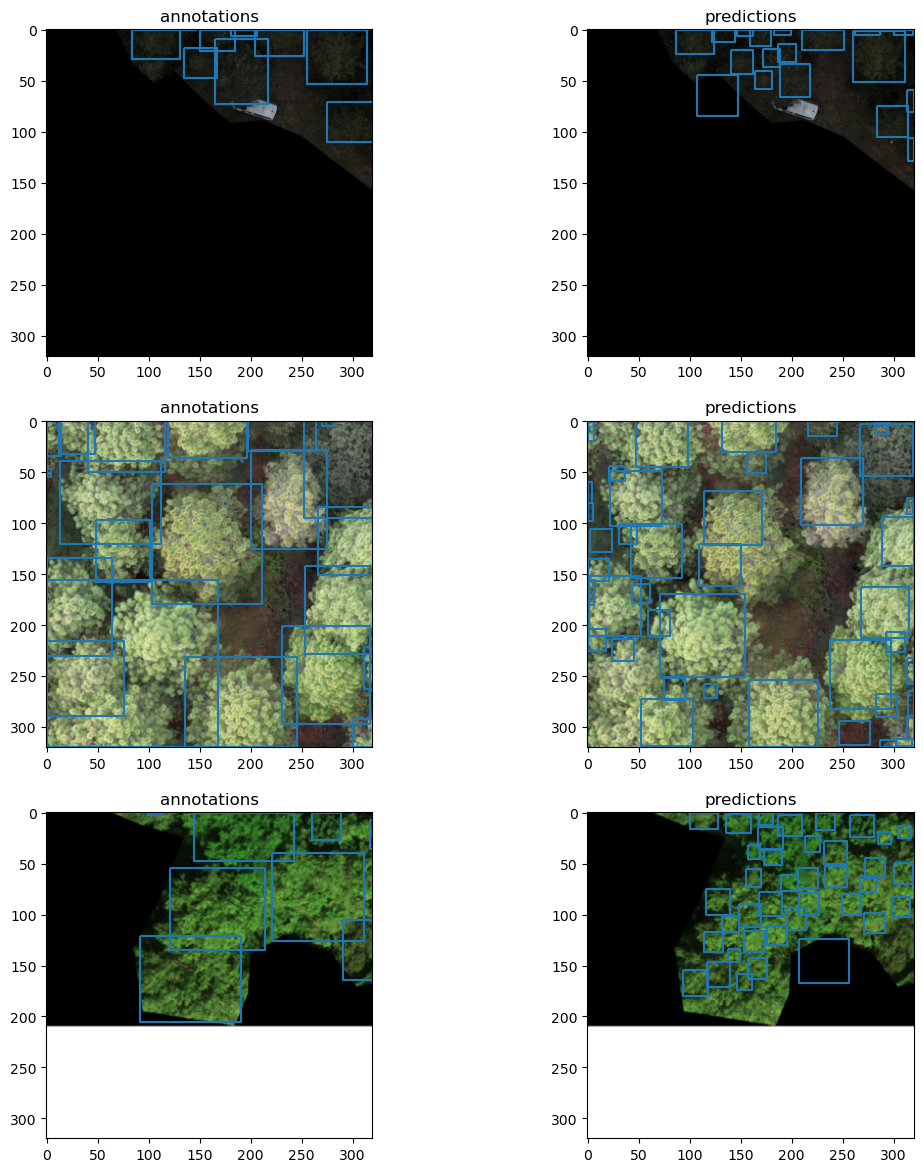

In [ ]:
# ignore species since the pre-trained model only predicts crowns
crown_label_dict = {"Tree": 0}
crown_annot_gdf = val_gdf.assign(**{"label": "Tree"})

# plot only a tiny sample of images
n_plot_imgs = 3
plot_img_filenames = val_img_filenames.sample(n_plot_imgs, random_state=random_state)
fig = deepforest_utils.plot_annot_vs_pred(
    pre_pred_gdf[pre_pred_gdf["image_path"].isin(plot_img_filenames)],
    val_gdf[val_gdf["image_path"].isin(plot_img_filenames)],
    val_img_dir,
    # since we are only predicting tree crowns, do not use any color code and do not add
    # any legend
    plot_pred_kwargs={"legend": False, "column": None},
    plot_annot_kwargs={"legend": False, "column": None},
)

As we can see, there is much room for improvement. We can better quantify the visual impressions by computing (again, *locally*) the precision (proportion of predicted objects that have a ground truth positive match - *for a given IoU threshold*) and recall (proportion of ground truth objects that have a true positive match - *for a given IoU threshold*):

In [ ]:
eval_results = evaluate(
    pre_pred_gdf, crown_annot_gdf, eval_iou_threshold, crown_label_dict
)
# eval_results["results"]
eval_results["box_precision"], eval_results["box_recall"]

(0.19584055459272098, 0.2297029702970297)

## 2. Fine-tuning the tree crown detection model

Let us now try to improve the results by fine-tuning the pre-trained model with the training annotations. To that end, we will run the ephemeral app again. Since we have already run the app before, building times for subsequent runs will be *much faster* - I would even say *negligible*. Additionally, even though the first run was "ephemeral", we will not need to upload the images again since in the deepforest-modal-app setup the data/images uploaded via the `ensure_imgs` method are not stored in the app container but in a **persistent storage volume** (see [the Modal user guide](https://modal.com/docs/guide) for more details on how apps, volumes and many more Modal features work). In fact, you can navigate the active volumes in the Storage section of your user dashboard at *modal.com/storage/\<your-modal-username\>*.

Within the ephemeral app, we can use the `retrain_crown_model` method to fine-tune our model, which takes the following arguments:
- the training annotations as a pandas data frame like the `val_gdf` shown above (i.e., [following the DeepForest format](https://deepforest.readthedocs.io/en/v1.5.0/user_guide/11_training.html))
- the path to the remote folder where images are stored within the data storage volume
- an optional test/validation data frame (if we want to compute loss scores on the test/validation data set)
- a destination file path to store the resulting model checkpoint, relative to the model storage volume (if not provided, a path will be automatically generated)
- any additional keyword arguments passed to [the underlying PyTorch Lightning Trainer](https://lightning.ai/docs/pytorch/LTS/common/trainer.html), e.g., [a compatible logger](https://lightning.ai/docs/pytorch/LTS/api_references.html#loggers) such as [Comet](https://www.comet.com).

Note again that the resulting model checkpoint will be uploaded to a **persistent storage volume** so that we do not lose it after shutting down the ephemeral app and we can use it in subsequent runs. Nonetheless, there is no reason why we should not run inference with the fine-tuned model right after training:

In [ ]:
# create a comet logger
comet_logger = loggers.CometLogger(
    api_key=comet_ml_api_key,
    project=comet_ml_project_name,
    workspace=comet_ml_workspace,
)

with modal.enable_output():
    # run ephemeral app
    with dma.app.run():
        # start app instance
        app = dma.DeepForestApp()

        # retrain crown model
        fine_tuned_filepath = path.join(dataset_id, "crown-fine-tune.pl")
        # ignore species since we want to fine-tune the crown prediction only
        app.retrain_crown_model.remote(
            train_gdf.assign(**{"label": "Tree"}),
            remote_img_dir,
            test_df=val_gdf.assign(**{"label": "Tree"}),
            dst_filepath=fine_tuned_filepath,
            logger=comet_logger,
        )

        # predict with the fine-tuned model
        ft_pred_gdf = pd.concat(
            [
                app.predict.remote(
                    img_filename,
                    remote_img_dir,
                    checkpoint_filepath=fine_tuned_filepath,
                    iou_threshold=pred_iou_threshold,
                )
                for img_filename in val_img_filenames
            ],
            ignore_index=True,
        )

### Evaluate the fine-tuned tree crown predictions, locally

Again, once we have performed fine-tuning and inference on a GPU-enabled ephemeral Modal app, we can evaluate the predictions locally:

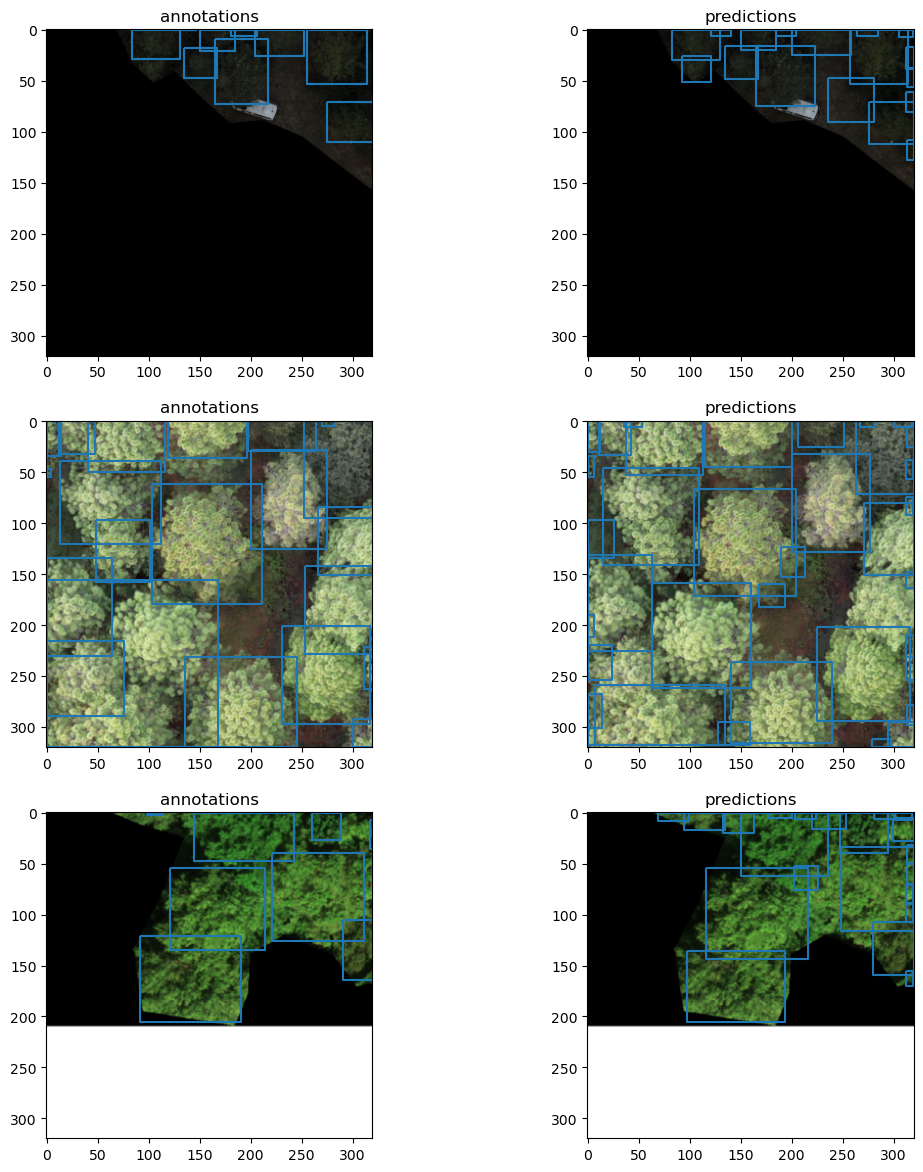

In [ ]:
fig = deepforest_utils.plot_annot_vs_pred(
    ft_pred_gdf[ft_pred_gdf["image_path"].isin(plot_img_filenames)],
    crown_annot_gdf[crown_annot_gdf["image_path"].isin(plot_img_filenames)],
    val_img_dir,
    # since we are only predicting tree crowns, do not use any color code and do not add
    # any legend
    plot_pred_kwargs={"legend": False, "column": None},
    plot_annot_kwargs={"legend": False, "column": None},
)

The fine-tuning has seemingly improved the tree crown predictions, but let us again confirm this with the precision and recall metrics:

In [ ]:
ft_eval_results = evaluate(
    ft_pred_gdf, crown_annot_gdf, eval_iou_threshold, crown_label_dict
)
# eval_results["results"]
ft_eval_results["box_precision"], ft_eval_results["box_recall"]

(0.5781637717121588, 0.46534653465346537)

In line with the plots, the metrics clearly confirm the improvement of fine-tuning procedure. While there is plenty of room for further performance gains, these are beyond the scope of this example.

## 3. Train a multi-species classifier

There are several ways to perform multi-species tree detection on aerial imagery. The most straight-forward is to train a multi-class object detection model such as Faster R-CNN or RetinaNet. Nonetheless, training such a model can be challenging when having multiple classes with many of them showing low occurrence within the dataset. Instead, we can use the fine-tuned DeepForest model to predict tree crowns and subsequently apply an image classification model to the cropped tree crown image. This is in fact the purpose of [the DeepForest `CropModel`](https://deepforest.readthedocs.io/en/v1.5.2/user_guide/03_cropmodels.html) class.

We can train a `CropModel` in an ephemeral app using the `train_crop_model` function, which takes the multi-species training annotations and the path to the image folder in the data storage volume as positional arguments. Additionally, we can provide the validation annotations to evaluate the loss on the validation dataset as well, specify the destination path to save the trained checkpoint (otherwise it will be automatically generated) and pass further keyword arguments to the PyTorch Lightning such as the maximum number of epochs or (again) a compatible logger:

In [ ]:
# multi-species detection on the fine-tuned crown predictions
# for the crop model, use a sample of the training data only
crop_train_img_filenames = pd.Series(train_gdf["image_path"].unique()).sample(
    n_crop_train_images, random_state=random_state
)
# # alternative: focus on top k species?
# k = 2
# train_gdf[train_gdf["label"].isin(train_gdf["label"].value_counts().iloc[:k].index)][
#     "image_path"
# ]
crop_train_gdf = train_gdf[train_gdf["image_path"].isin(crop_train_img_filenames)]
with modal.enable_output():
    # run ephemeral app
    with dma.app.run():
        # start app instance
        app = dma.DeepForestApp()

        # train crop model
        crop_filepath = path.join(dataset_id, "crop.pl")
        app.train_crop_model.remote(
            crop_train_gdf,
            remote_img_dir,
            test_df=val_gdf,
            dst_filepath=crop_filepath,
            create_trainer_kwargs={
                "max_epochs": crop_max_epochs,
                "logger": comet_logger,
            },
        )

        # inference with fine-tuned and crop model
        # TODO: how to let the app handle this?
        crop_model_num_classes = pd.concat(
            [crop_train_gdf["label"], val_gdf["label"]]
        ).nunique()
        ms_pred_gdf = pd.concat(
            [
                app.predict.remote(
                    img_filename,
                    remote_img_dir,
                    checkpoint_filepath=fine_tuned_filepath,
                    crop_model_filepath=crop_filepath,
                    crop_model_num_classes=crop_model_num_classes,
                    iou_threshold=pred_iou_threshold,
                )
                for img_filename in val_img_filenames
            ],
            ignore_index=True,
        )

### Evaluate the multi-species predictions, locally

Again, once we have trained the multi-species model and use it together with the crown model to perform multi-species inference on a GPU-enabled ephemeral Modal app, we can evaluate the predictions locally:

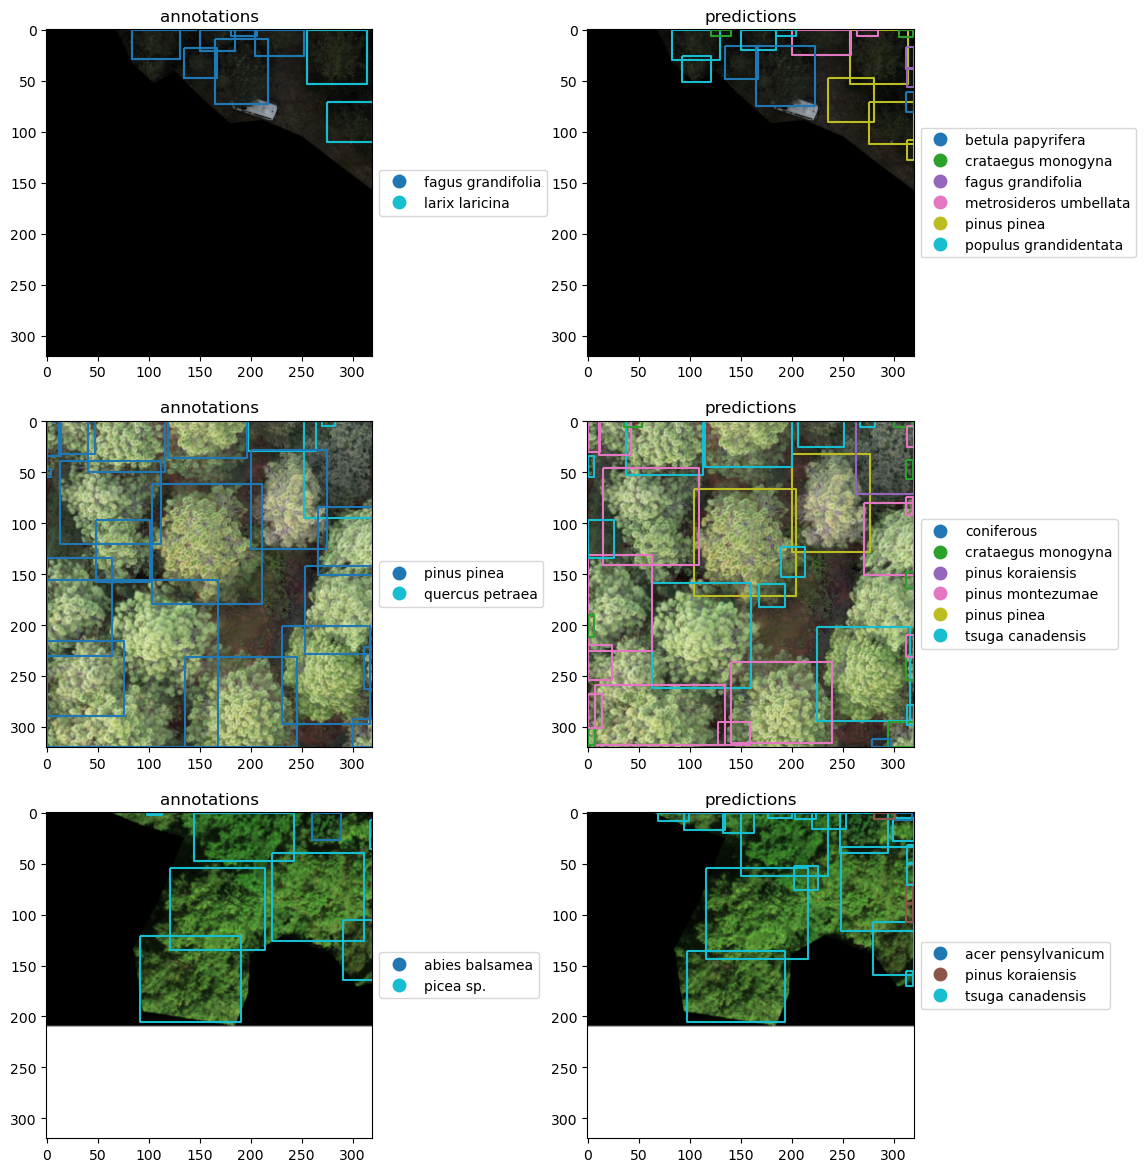

In [ ]:
fig = deepforest_utils.plot_annot_vs_pred(
    ms_pred_gdf[ms_pred_gdf["image_path"].isin(plot_img_filenames)],
    val_gdf[val_gdf["image_path"].isin(plot_img_filenames)],
    val_img_dir,
    label_dict=species_label_dict,
)

First of all please excuse the lack of a consistent and unified color scheme, which can be a bit tricky for categorical multiplots with geopandas (I am working on it though). In any case, the species classification seems to perform very poorly, with only some matches for the "pinus pinea" in the second image. Let us now quantify the performance:

In [ ]:
# evaluate results locally
ms_eval_results = evaluate(ms_pred_gdf, val_gdf, eval_iou_threshold, species_label_dict)
class_eval_df = ms_eval_results["class_recall"]
# use species names rather than integer ids
class_eval_df = class_eval_df.assign(
    **{"label": class_eval_df["label"].map(species_label_dict)}
)
# drop species with no occurrence within the validation data set
class_eval_df = class_eval_df[class_eval_df["size"] > 0]
class_eval_df

,label,recall,precision,size
0,betula papyrifera,0.000000,0.000000,32
1,tsuga canadensis,0.303030,0.303030,33
2,picea abies,0.000000,0.000000,14
3,acer saccharum,0.000000,0.000000,17
4,betula sp.,0.000000,0.000000,5
5,pinus sylvestris,0.000000,0.000000,7
6,picea rubens,0.000000,0.000000,25
7,betula alleghaniensis,0.000000,0.000000,3
8,larix decidua,0.000000,0.000000,1
9,fagus grandifolia,0.000000,0.000000,6


As we can see, there are very few species classification matches (only for "tsuga canadensis" and "pinus pinea").

**Note however that the purpose of this notebook is to illustrate how to use the deepforest-modal app**, and therefore we have saved computing costs by using a very small fraction of the available training and validation data (100 out ouf 1061 training images and 10 out of 303 validation images) for the multi-species model. The results would certainly be improved by including all the training and validation data, potentially allowing more epochs in training and many other possitilities that are way outside the scope of this notebook.

## Annex: plotting training metrics from the logger

We can use the comet logger to plot some training metrics:

<Axes: xlabel='step'>

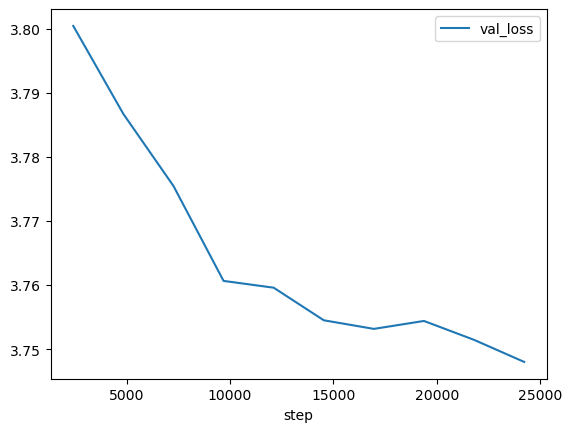

In [ ]:
experiment = comet_ml.API(api_key=comet_ml_api_key).get_experiment(
    project_name=comet_ml_project_name,
    workspace=comet_ml_workspace,
    experiment=comet_logger.experiment.get_key(),
)


def plot_metric(metric_name: str) -> plt.Axes:
    """Plot a the evolution of a training metric."""
    metric_df = pd.DataFrame.from_records(experiment.get_metrics(metric_name))
    return metric_df.assign(
        **{metric_name: metric_df["metricValue"].astype(float)}
    ).plot(x="step", y=metric_name, kind="line")


plot_metric("val_loss")

<Axes: xlabel='step'>

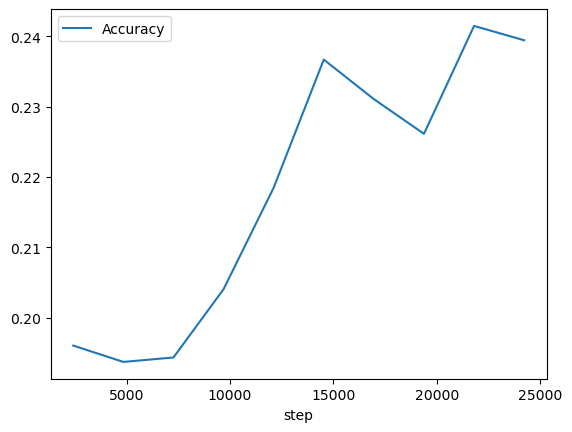

In [ ]:
plot_metric("Accuracy")

## References

1. Weinstein, B. G., Marconi, S., Aubry‐Kientz, M., Vincent, G., Senyondo, H., & White, E. P. (2020). DeepForest: A Python package for RGB deep learning tree crown delineation. Methods in Ecology and Evolution, 11(12), 1743-1751.
2. Beloiu Schwenke, M., Xia, Z., Novoselova, I., Gessler, A., Kattenborn, T., Mosig, C., Puliti, S., Waser, L., Rehush, N., Cheng, Y., Xinliang, L., Griess, V. C., & Mokroš, M. (2025). TreeAI Global Initiative - Advancing tree species identification from aerial images with deep learning (TreeAI.V1.2) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.15351054